In [1008]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

In [1009]:
data = pd.read_csv('data/cleaned_data.csv', 
                   parse_dates=['Fully Paid','Approved']).drop(['Unnamed: 0'],axis=1)

In [1010]:
# Select only the past 5 years of data to make sure the data is relevant
data = data[data['Fully Paid'] > '2014-05-15']

In [1011]:
data = data.reset_index(drop=True)

### Pre-processing and evaluating the data 

* Data has both continuous and categorical variable. In order to conduct regression analysis to predict the duration of the building permit, we need to convert the categorical variables into numeric dummies.
* Then we need to combine the relevant columns of the data into a single dataframe, on whic we will perform the regression analysis.

In [1012]:
# convert the categorical variables into numeric dummies
df_cat = pd.get_dummies(data[['Borough', 'Building Type', 'Efiling Filed',
        'Applicant Professional Title', 'Professional Cert','Proposed Occupancy']], 
         drop_first = True)

# by specifying "drop_first=True" we ensure that there is no correlation among the dummies.
# Basically, for n categories we will have n-1 dummies.

df_cat = df_cat.rename(columns={'Building Type_OTHERS':'Building Type',
                                'Efiling Filed_Y':'Efiled',
                               'Applicant Professional Title_RA':'Pro Title',
                               'Professional Cert_Y':'Pro Certified'})
df_cat.head()

,Borough_BROOKLYN,Borough_MANHATTAN,Borough_QUEENS,Borough_STATEN ISLAND,Building Type,Efiled,Pro Title,Pro Certified,Proposed Occupancy_E,Proposed Occupancy_M,Proposed Occupancy_Other,Proposed Occupancy_R-2,Proposed Occupancy_R-3,Proposed Occupancy_S-2,Proposed Occupancy_U
0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0
1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1
2,1,0,0,0,1,1,1,0,0,0,0,1,0,0,0
3,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0
4,1,0,0,0,1,1,1,0,0,0,0,1,0,0,0


In [1013]:
# create a dataframe with numeric values
numeric_cols = ['Total Est. Fee','Proposed Dwelling Units','Proposed Zoning Sqft', 
              'Proposed No. Of Stories','Total_Construction_Floor_Area',
              'Proposed Height','Duration']

numeric_df = data[numeric_cols]

In [1014]:
df = pd.merge(df_cat, numeric_df, left_index=True, right_index=True)

In [1015]:
df

,Borough_BROOKLYN,Borough_MANHATTAN,Borough_QUEENS,Borough_STATEN ISLAND,Building Type,Efiled,Pro Title,Pro Certified,Proposed Occupancy_E,Proposed Occupancy_M,...,Proposed Occupancy_R-3,Proposed Occupancy_S-2,Proposed Occupancy_U,Total Est. Fee,Proposed Dwelling Units,Proposed Zoning Sqft,Proposed No. Of Stories,Total_Construction_Floor_Area,Proposed Height,Duration
0,0,0,1,0,0,1,1,0,0,0,...,1,0,0,243.00,2.0,2700,2,4050,28,158.0
1,0,0,1,0,0,1,1,1,0,0,...,0,0,1,100.00,NaN,300,1,300,12,87.0
2,1,0,0,0,1,1,1,0,0,0,...,0,0,0,2209.84,8.0,5994,4,7884,50,193.0
3,0,0,0,1,0,1,1,0,0,0,...,1,0,0,587.96,1.0,1245,3,2058,37,234.0
4,1,0,0,0,1,1,1,0,0,0,...,0,0,0,5082.32,16.0,15045,8,18932,80,89.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10237,0,0,0,1,0,1,1,0,0,0,...,0,0,1,100.00,NaN,650,1,650,14,43.0
10238,0,0,0,1,0,1,1,1,0,0,...,1,0,0,134.82,1.0,1498,2,2247,29,92.0
10239,1,0,0,0,1,1,1,0,0,0,...,0,0,0,1519.70,6.0,4339,4,5845,54,414.0
10240,0,0,0,1,1,1,1,1,0,1,...,0,0,0,1890.20,4.0,5271,3,7270,34,115.0


#### Examining the distribution of the target variable (duration)

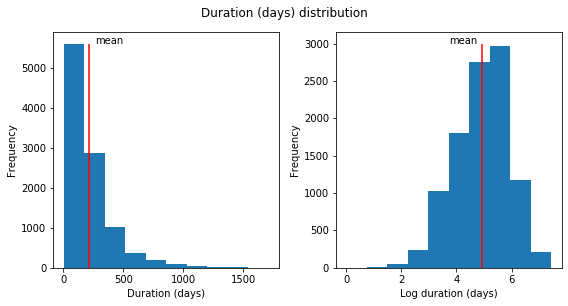

In [1016]:
# Plot the target variable distribution
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
data[['Duration']].plot.hist(ax=ax1, legend=False)
ax1.vlines(data[['Duration']].mean(), 0, 5600, color='red')
ax1.annotate('mean', (data[['Duration']].mean()+50, 5600))
ax1.set_xlabel('Duration (days)')
np.log(data[['Duration']]).plot.hist(ax=ax2, legend=False);
ax2.vlines(np.log(data[['Duration']]).mean(), 0, 3000, color='red')
ax2.annotate('mean', (np.log(data[['Duration']]).mean()-1.2, 3000))
ax2.set_xlabel('Log duration (days)')
plt.suptitle('Duration (days) distribution', y=1.05)
plt.tight_layout()

In [1017]:
print("The log mean duration is e^{:.2f} = {:.1f} days".format(
    (np.log(data[['Duration']]).mean()[0]), np.exp(np.log(data[['Duration']]).mean()[0])))
print("The mean duration is {:.1f} days".format(data[['Duration']].mean()[0]))

The log mean duration is e^4.93 = 137.8 days
The mean duration is 210.5 days


* We can see that the duration is not normally distributed, it is skewed to right. Log presentation of the duration shows a more normal distribution. 
* Hence, we will use the log of the duration for the regression analysis.

#### Preprocessing data
* We apply sklearn's StandardScaler to standardize the numeric columns to improve the regression performance
* We apply SimpleImputer to fill in missing values

In [1018]:
from sklearn.impute import SimpleImputer # Impute the missing or NaN values
from sklearn.preprocessing import StandardScaler

def pre_process(cat_data, numeric_data):
    """
    Apply scaling to the categorical data, combine the two dataframes, 
    and apply imputer to fill in the NaN values. Return a combined dataframe with scaled
    numeric values and imputed values for NaNs. 
    """
    # apply the StandardScaler to standardize the numeric values
    scaled_data = StandardScaler().fit_transform(numeric_data)
    scaled_data = pd.DataFrame(scaled_data, columns=numeric_data.columns)

    # Create a combined dataframe with the columns to use for prediction
    combined_df = pd.merge(cat_data, scaled_data, left_index=True, right_index=True)

    # apply the simple imputer to fill in missing values
    imp_data = SimpleImputer(strategy='most_frequent').fit_transform(combined_df)
    return pd.DataFrame(imp_data, columns=combined_df.columns)

### 1. Regression Analysis

In [1019]:
# import the necessary moduls
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score # Import cross validation model
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Create the X and y for the regression
X_1 = df.drop('Duration', axis=1)
y_1 = np.log(df['Duration']).values.reshape(-1,1) # taking the log values for y

imputer = SimpleImputer(strategy='most_frequent')
X = imputer.fit_transform(X_1)
y = imputer.fit_transform(y_1)

#### 1.1 Linear Regression - OLS (StatsModel)

In [1020]:
import statsmodels.api as sm

In [1021]:
X_ols = sm.add_constant(X_1) # adding a constant
X_ols = X_ols.drop(['Total_Construction_Floor_Area','Proposed Height'], axis=1)
model = sm.OLS(y, X_ols, missing='drop').fit()

print_model = model.summary()
print(print_model)

/Users/anushavan/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     233.6
Date:                Wed, 30 Oct 2019   Prob (F-statistic):               0.00
Time:                        22:25:03   Log-Likelihood:                -9912.4
No. Observations:                8513   AIC:                         1.986e+04
Df Residuals:                    8493   BIC:                         2.001e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [1022]:
print("The adjusted R square of the OLS model is: {:.2f}".format(model.rsquared_adj))

The adjusted R square of the OLS model is: 0.34


#### 1.2 Linear regression: sklearn LinearRegression

In [1023]:
from sklearn.linear_model import LinearRegression # import linear regression model

# use the most frequent values to fill in the NaN values
imputer = SimpleImputer(strategy='most_frequent') 
linreg = LinearRegression() # instantiate linear regression object
pipeline = make_pipeline(imputer, linreg)

# Split the data into training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

pipeline.fit(X_train, y_train)

# Get the mean value of the cross-validation results for R squared values.
cv_linreg = cross_val_score(pipeline, X_test, y_test, cv=5).mean()

y_pred_linreg = pipeline.predict(X_test)
mse_linreg = mean_squared_error(y_test, y_pred_linreg)

print('Average 5-Fold cross-verification R squared Score is: {:.2f}'.format(cv_linreg))
print('Mean squared error is: {:.2f}'.format(mse_linreg))
print('y mean is: {:.2f}, y standard deviation is: {:.2f}'.format(np.mean(y), np.std(y)))


Average 5-Fold cross-verification R squared Score is: 0.38
Mean squared error is: 0.59
y mean is: 4.93, y standard deviation is: 0.98


#### 1.3 Lasso Regression

In [1024]:
from sklearn.linear_model import Lasso

# instantiate lasso model
lasso = Lasso()

# list of alphas to use in grid search
alphas = {'alpha':np.logspace(-5,4,10)}

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

# conduct the grid search on the lasso regression to tune the best alpha parameter
gs_lasso = GridSearchCV(lasso, param_grid=alphas, scoring='r2')

gs_lasso.fit(X_train, y_train) # fit the gridsearch model

# get the best alpha from the gridsearch
best_alpha = gs_lasso.best_params_['alpha']

# fit the lasso model and get the score using the best alpha obtained from gridsearch
lasso = Lasso(alpha=best_alpha)

# Get the mean value of the cross-validation results for R squared values.
lasso_score = cross_val_score(lasso, X_test, y_test, cv=5).mean()

# predict the y values and calculate the mean squared error
y_pred_lasso = gs_lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

print("The best alpha is: {:.5f}".format(best_alpha))
print("R squared for the lasso regression is {:.2f}".format(lasso_score))
print('Mean squared error is: {:.2f}'.format(mse_lasso))
print('y mean is: {:.2f}, y standard deviation is: {:.2f}'.format(np.mean(y), np.std(y)))


/Users/anushavan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


The best alpha is: 0.00001
R squared for the lasso regression is 0.38
Mean squared error is: 0.59
y mean is: 4.93, y standard deviation is: 0.98


AttributeError: 'Lasso' object has no attribute 'coef_'

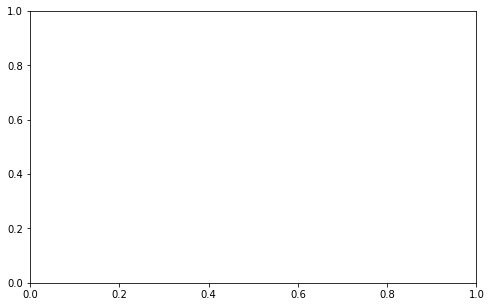

In [1025]:
# Lasso regression selects only the most important features. In our case those are the 
# Building type, Pro Certified and Proposed No. of Stories. 

fig, ax = plt.subplots(figsize=(8,5))
lasso_df = pd.DataFrame(lasso.coef_, X_1.columns).sort_values(by=0)
lasso_df[np.abs(lasso_df.values) >= 0.05].plot.barh(ax=ax, legend=False, color='red')
for i, v in enumerate(np.sort(lasso_df[np.abs(lasso_df.values) >= 0.05].values)): 
    # color coefficients red (negative) or green (positive)
    if v < 0:
        ax.get_children()[i].set_color('green')
    else:
        ax.get_children()[i].set_color('red')
plt.xlabel('Regression coefficients')
plt.title('Lasso regression: significant variables and coefficients');
plt.tight_layout()

* Lasso model is Helpful for feature selection. Identifies the most important variables.
* The most important variables are plotted in the above bar chart. The green bars indicate that the variable reduces the duration of the building permit, and the red bars indicate that the variable increases the duration of the building permit. For example, the duration:
    * increases if the building is type "other"
    * decreases if the application is professionally certified
    * increases if the building is in Manhattan.

#### 1.4 Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV

# Ridge regression with built-in cross-validation for alpha values
ridgecv = RidgeCV(alphas=np.logspace(-6, 6, 13))

# Split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# fit the model
ridgecv.fit(X_train, y_train)

# get the best alpha from cross-validation
alpha = ridgecv.alpha_
print("The best alpha is: {:.6f}".format(alpha))

# compute and print the R2: how much of the variance in the y is explained by the model.
ridge_R_cv = np.mean(cross_val_score(ridgecv, X_test, y_test, cv=5))

# predict the y values and calculate the mean squared error
ridge = Ridge(alpha=alpha)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print("R squared for the ridge regression is: {:.2f}".format(ridge_R_cv))
print('Mean squared error is: {:.2f}'.format(mse_ridge))
print('y mean is: {:.2f}, y standard deviation is: {:.2f}'.format(np.mean(y), np.std(y)))

### Linear models: conclusion
* Seems all models perform have roughly the same level of predictive power as defined by R squared.

In [ ]:
# Plot all regression R squares to see which one performs the best
r_squares = [cv_linreg,lasso_score,ridge_R_cv]

fig, ax1 = plt.subplots()

ax1.bar(range(len(r_squares)),np.sort(r_squares), width=0.5)
ax1.bar(range(len(r_squares)), [mse_ridge, mse_linreg, mse_lasso], width=0.1)
ax1.set_xticklabels(['','ridge','','linear','','lasso'])
ax1.set_ylabel('R squared (blue), MSE (orange)');
ax1.set_title('R squares and MSE of different regressions');
ax1.annotate(str(ridge_R_cv.round(2)), (0+0.1,ridge_R_cv+0.01))
ax1.annotate(str(cv_linreg.round(2)), (1+0.1,cv_linreg+0.005))
ax1.annotate(str(lasso_score.round(2)), (2+0.1,lasso_score+0.005));
ax1.annotate(str(mse_ridge.round(2)), (0,mse_ridge))
ax1.annotate(str(mse_linreg.round(2)), (1,mse_linreg+0.005))
ax1.annotate(str(mse_lasso.round(2)), (2,mse_lasso+0.005));

plt.tight_layout()

### 2. Other models

#### 2.1 ExtraTreesRegressor 

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

# parameters for gridsearch
parameters = {'n_estimators':(np.arange(10,150, 5)), 'max_features':np.arange(1,20, 1)}

extratrees = ExtraTreesRegressor()

# Split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# Use randomized gridsearch to tune the hyperparameters
rand_gs = RandomizedSearchCV(extratrees, parameters, cv=5)
rand_gs.fit(X_train, np.ravel(y_train))

# get the R squared score
extra_score = rand_gs.score(X_test, y_test).round(2)

# extract the best parameters from the gridsearch
best_params = rand_gs.best_params_

# fit the extratree regressor with the best parameters
extratrees = ExtraTreesRegressor(**best_params).fit(X_train, y_train)

# predit the y
y_pred_extra = extratrees.predict(X_test)
mse_extra = mean_squared_error(y_test, y_pred_extra)

print('Mean squared error is: {:.2f}'.format(mse_extra))
print("R squared for the ExtraTreesRegressor is: {:.2f}".format(extra_score))

In [ ]:
extra_df = pd.DataFrame({'Importance':100.0 * (extratrees.feature_importances_ /
                                            extratrees.feature_importances_.max())}, 
                     index=X_1.columns)
fig, ax = plt.subplots(figsize=(8,6))
extra_df.sort_values(by='Importance').plot(kind='barh', ax=ax, legend=False)
plt.title('Variable importance')
plt.xlabel('Relative importance');

#### 2.2 Gradient Boosting

In [ ]:
# set the parameters of the model
from sklearn import ensemble
from sklearn.metrics import mean_squared_error

params = {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}

# gs = ensemble.GradientBoostingRegressor(**params)
gs = ensemble.GradientBoostingRegressor()

# Split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), 
                                                    test_size=0.30, random_state=1)
param_dist = {'n_estimators': np.arange(300,1000,50), 'max_depth': np.arange(2,20,2), 
          'learning_rate': np.logspace(-4,1,6)}

random_search = RandomizedSearchCV(gs, param_distributions=param_dist)
random_search.fit(X_train, y_train)

In [ ]:
# fit the gs model with the best parameters found in the previous step
gs_params = random_search.best_params_
gs = ensemble.GradientBoostingRegressor(**gs_params)
gs.fit(X_train, y_train)
gs_rsquared = gs.score(X_test, y_test)
mse = mean_squared_error(y_test, gs.predict(X_test))
print("MSE: {:.3f}".format(mse))
print("R squared: {:.2f}".format(gs_rsquared))

In [ ]:
gs_df = pd.DataFrame({'Importance':100.0 * (gs.feature_importances_ /
                                            gs.feature_importances_.max())}, 
                     index=X_1.columns)
fig, ax = plt.subplots(figsize=(8,6))
gs_df.sort_values(by='Importance').plot(kind='barh', ax=ax, legend=False)
plt.title('Variable importance')
plt.xlabel('Relative importance');